In [116]:
import plotly.graph_objects as go
import networkx as nx
import os

# reading input log file

test_name = "ddmd"
# test_name = "vist"
# test_name = "seq9f9s"

stat_path=f"example_stat/{test_name}"
image_path=f"{stat_path}/images"

VFD_ACCESS_SKIP=10

ADD_ADDR=True


In [117]:
# My utility functions
import utils.stat_loader as sload
import utils.stat_print as sp
import utils.vfd_stat2graph as vfd2g
import utils.vfd_graph2sankey as vfd2sk
import utils.full_stat2graph as f2g

# Improve Functions
## TODO
- Add dataset nodes
- Add file address ordering nodes


In [118]:
STAGE_START = 1
STAGE_END = 1


TASK_ORDER_LIST = sload.load_task_order_list(stat_path)
STAGE_END = sload.correct_end_stage(TASK_ORDER_LIST, STAGE_END)

TASK_ORDER_LIST = sload.current_task_order_list(TASK_ORDER_LIST, STAGE_START, STAGE_END)

TASK_LISTS = list(TASK_ORDER_LIST.keys())

print(f"TASK_ORDER_LIST = {TASK_ORDER_LIST}")
TASK_LISTS


TASK_ORDER_LIST = {'aggregate': 1}


['aggregate']

In [119]:
vfd_files = sload.find_files_with_pattern(stat_path, "vfd")
# vfd_files = vfd_files[0:1]
print(f"vfd_files: {vfd_files}")

vfd_dict = sload.load_stat_json(vfd_files)
# print(vfd_dict)


vol_files = sload.find_files_with_pattern(stat_path, "vol")
# vol_files = vol_files[0:1]
print(f"vol_files: {vol_files}")

vol_dict = sload.load_stat_json(vol_files)

print("loading json done")

vfd_files: ['example_stat/ddmd/40876-vfd_data_stat.json', 'example_stat/ddmd/40930-vfd_data_stat.json', 'example_stat/ddmd/40983-vfd_data_stat.json', 'example_stat/ddmd/41036-vfd_data_stat.json', 'example_stat/ddmd/41249-vfd_data_stat.json', 'example_stat/ddmd/41382-vfd_data_stat.json', 'example_stat/ddmd/41515-vfd_data_stat.json', 'example_stat/ddmd/41648-vfd_data_stat.json', 'example_stat/ddmd/41781-vfd_data_stat.json', 'example_stat/ddmd/41914-vfd_data_stat.json', 'example_stat/ddmd/42047-vfd_data_stat.json', 'example_stat/ddmd/42180-vfd_data_stat.json', 'example_stat/ddmd/42528-vfd_data_stat.json', 'example_stat/ddmd/42584-vfd_data_stat.json', 'example_stat/ddmd/42845-vfd_data_stat.json']
loading example_stat/ddmd/40876-vfd_data_stat.json
loading example_stat/ddmd/40930-vfd_data_stat.json
loading example_stat/ddmd/40983-vfd_data_stat.json
loading example_stat/ddmd/41036-vfd_data_stat.json
loading example_stat/ddmd/41249-vfd_data_stat.json
loading example_stat/ddmd/41382-vfd_data_st

In [120]:
# Show VFD Tracker overhead
sp.show_all_overhead("VFD", vfd_dict)

Total VFD overhead: 11812395.532000002 ms
Total POSIX-OPEN-Time(us): 37439.92200000001 us
Total POSIX-CLOSE-Time(us): 10790.579000000003 us
Total POSIX-READ-Time(us): 1389001.7550000018 us
Total POSIX-WRITE-Time(us): 43293.46100000019 us
Total POSIX-DELETE-Time(us): 0.0 us


In [121]:
import copy

# Transform VOL dict to list of dict
def get_vol_dset_info(vol_dict):
    vol_dset_info = {}
    for file,all_stat in vol_dict.items():
        # print(f"all_stat: {all_stat}")
        for stat in all_stat:
            for k,v in stat.items():
                if 'datasets' in v.keys():
                    dset_info = copy.deepcopy(v)
                    # print(f"file: {file}, k: {k}, v: {v}")
                    task_name = dset_info['task_name']
                    dstasets_list = dset_info['datasets']
                    # print(f"task_name: {task_name}, dstasets_list: {dstasets_list}")
                    del dset_info['task_name']
                    if task_name in vol_dset_info:
                        vol_dset_info[task_name]['datasets'].extend(dstasets_list)
                    else:
                        vol_dset_info[task_name] = dset_info
    return vol_dset_info

vol_dset_info = get_vol_dset_info(vol_dict)

cnt=0
for k,v in vol_dset_info.items():
    print(f"{k} :")
    datasets_list = v['datasets']
    print(f"- {datasets_list[0]}")


openmm-40876 :
- {'dset_name': 'contact_map', 'start_time': 1711558432816227, 'end_time': 1711558432819230, 'dt_class': 'H5T_VLEN', 'ds_class': 'H5S_SCALAR', 'layout': 'H5D_CHUNKED', 'storage_size': 0, 'dset_n_elements': 100, 'dimension_cnt': 1, 'dimensions': [100], 'dset_type_size': 16, 'dataset_read_cnt': 0, 'dataset_write_cnt': 1, 'access_type': 'write_only', 'dset_offset': -1, 'dset_select_type': 'H5S_SEL_ALL', 'dset_select_npoints': 100, 'access_orders': [1]}
openmm-40930 :
- {'dset_name': 'contact_map', 'start_time': 1711558429477489, 'end_time': 1711558429481516, 'dt_class': 'H5T_VLEN', 'ds_class': 'H5S_SCALAR', 'layout': 'H5D_CHUNKED', 'storage_size': 0, 'dset_n_elements': 100, 'dimension_cnt': 1, 'dimensions': [100], 'dset_type_size': 16, 'dataset_read_cnt': 0, 'dataset_write_cnt': 1, 'access_type': 'write_only', 'dset_offset': -1, 'dset_select_type': 'H5S_SEL_ALL', 'dset_select_npoints': 100, 'access_orders': [1]}
openmm-40983 :
- {'dset_name': 'contact_map', 'start_time': 17

In [122]:
def prepare_sankey_stat_full(G, vol_dset_info):
    sankey_edge_attr = {}
    for edge in G.edges():
        edge_type = G.edges[edge]['edge_type']

        data_access_bytes = 0
        data_access_cnt = 0
        metadata_access_bytes = 0
        metadata_access_cnt = 0
        bandwidth = 0
        file_stat = G.edges[edge]['file_stat']
        # edge_types: {'dset-task', 'page-file', 'page-dset', 'file-page', 'dset-page', 'task-dset'}
        if edge_type == 'dset-task' or edge_type == 'task-dset':
            print(f"edge: {edge} -> {edge_type}")
            if edge_type == 'dset-task': 
                task_name = edge[1]
                dset_name = edge[0]
            else: 
                task_name = edge[0]
                dset_name = edge[1]
            
            all_dset_list = vol_dset_info[task_name]['datasets']
            # pick the dataset with the same name
            match_dset_list = []
            dset_base_name = dset_name.split('-')[0]
            for dset in all_dset_list:
                if dset['dset_name'] == dset_base_name:
                    if edge_type == 'dset-task' and dset['access_type'] == 'read_only':
                        match_dset_list.append(dset)
                    elif edge_type == 'task-dset' and dset['access_type'] == 'write_only':
                        match_dset_list.append(dset)
            
            # print(f"match_dset_list: {match_dset_list}")
            for dset in match_dset_list:
                access_time_in_sec += dset['start_time'] - dset['end_time']
                if dset['access_type'] == 'read_only':
                    access_cnt += dset['dataset_read_cnt']
                elif dset['access_type'] == 'write_only':
                    access_cnt += dset['dataset_write_cnt']
                access_size += (dset['dset_type_size'] * dset['dset_type_size'])
            
            # # want dataset size access info from file only
            # dset_stat = G.edges[edge]['dset_obj_stat']
            # position = G.nodes[edge[1]]['pos']
            # for meta_type in dset_stat['metadata']:
            #     meta_stat = dset_stat['metadata'][meta_type]
            #     metadata_access_bytes += meta_stat['read_bytes'] + meta_stat['write_bytes']
            #     metadata_access_cnt += meta_stat['read_cnt'] + meta_stat['write_cnt']
            # for data_type in dset_stat['data']:
            #     data_stat = dset_stat['data'][data_type]
            #     data_access_bytes += data_stat['read_bytes'] + data_stat['write_bytes']
            #     data_access_cnt += data_stat['read_cnt'] + data_stat['write_cnt']
            
            access_time_in_sec = access_time_in_sec/1000000
            # access_cnt = metadata_access_cnt + data_access_cnt
            # access_size = metadata_access_bytes + data_access_bytes
            bandwidth = access_size / access_time_in_sec
            
        elif edge_type == 'page-file' or edge_type == 'file-page':
            # want page size access info and file info
            page_stat = G.edges[edge]['page_stat']
            position = G.nodes[edge[1]]['pos']
            access_cnt = page_stat['access_cnt']
            access_size = page_stat['size']
            
            access_time_in_sec = (file_stat['close_time(us)'] - file_stat['open_time(us)'])/1000000
            bandwidth = access_cnt * access_size / access_time_in_sec
            
        elif edge_type == 'dset-page' or edge_type == 'page-dset':
            # want page size access info only
            dset_stat = G.edges[edge]['dset_stat']
            position = G.nodes[edge[1]]['pos']
            
            for meta_type in dset_stat['metadata']:
                meta_stat = dset_stat['metadata'][meta_type]
                metadata_access_bytes += meta_stat['read_bytes'] + meta_stat['write_bytes']
                metadata_access_cnt += meta_stat['read_cnt'] + meta_stat['write_cnt']
            for data_type in dset_stat['data']:
                data_stat = dset_stat['data'][data_type]
                data_access_bytes += data_stat['read_bytes'] + data_stat['write_bytes']
                data_access_cnt += data_stat['read_cnt'] + data_stat['write_cnt']
                
            page_stat = G.edges[edge]['page_stat']
            position = G.nodes[edge[1]]['pos']
            
            access_cnt = metadata_access_cnt + data_access_cnt #page_stat['access_cnt']
            access_size = page_stat['size']
            
            access_time_in_sec = (file_stat['close_time(us)'] - file_stat['open_time(us)'])/1000000 # change to dataset open and close time
            bandwidth = access_cnt * access_size / access_time_in_sec

        else:
            # set all values to 0
            position = (0,0)
            access_cnt = 0
            access_size = 0
        
        edge_attr = {
                'position': position,
                'access_cnt': access_cnt,
                'access_size': access_size,
                'data_access_size': data_access_bytes,
                'data_access_cnt': data_access_cnt,
                'metadata_access_size': metadata_access_bytes,
                'metadata_access_cnt': metadata_access_cnt,
                'bandwidth': bandwidth,
                'operation': file_stat['access_type'],}
        sankey_edge_attr[edge] = edge_attr
    
    nx.set_edge_attributes(G, sankey_edge_attr)

In [123]:
def inc_in_dict(dic, k):
    if k not in dic:
        dic[k] = 0
    else:
        dic[k]+=1



G_VFD = nx.DiGraph()
G_VFD = f2g.add_task_dset_file_nodes(G_VFD, vfd_dict, TASK_ORDER_LIST, add_addr=ADD_ADDR)

# sp.display_all_edges_attr(G_VFD)
# sp.display_all_nodes_position(G_VFD)

In [124]:


file_page_nodes_attr, dset_page_edges = f2g.get_file_dset_maps(vfd_dict, TASK_ORDER_LIST)

# for k,v in file_page_nodes_attr.items(): print(f"file_page_nodes_attr: {k} -> {v}")
# for k,v in add_edge_stat.items(): print(f"add_edge_stat: {k} -> {v}")



file_page_nodes_attr: {'[0-49)': {'pos': (0, 0), 'rpos': 0, 'range': (0, 49), 'size': 3211264}, '[49-98)': {'pos': (0, 1), 'rpos': 0, 'range': (49, 98), 'size': 3211264}, '[98-147)': {'pos': (0, 2), 'rpos': 0, 'range': (98, 147), 'size': 3211264}, '[147-196)': {'pos': (0, 3), 'rpos': 0, 'range': (147, 196), 'size': 3211264}}
dset_page_edges: {('[0-49)', 'contact_map-1-R'): {'access_cnt': 60, 'access_type': 'read'}, ('contact_map-1-W', '[49-98)'): {'access_cnt': 2, 'access_type': 'write'}, ('contact_map-1-W', '[98-147)'): {'access_cnt': 16, 'access_type': 'write'}, ('[0-49)', 'file-1-R'): {'access_cnt': 96, 'access_type': 'read'}, ('file-1-W', '[0-49)'): {'access_cnt': 2, 'access_type': 'write'}, ('[0-49)', 'fnc-1-R'): {'access_cnt': 1620, 'access_type': 'read'}, ('fnc-1-W', '[0-49)'): {'access_cnt': 2, 'access_type': 'write'}, ('[0-49)', 'point_cloud-1-R'): {'access_cnt': 276, 'access_type': 'read'}, ('point_cloud-1-W', '[0-49)'): {'access_cnt': 10, 'access_type': 'write'}, ('point_clo

In [125]:
def update_nodes_edges(G,add_edge_stat, edges_to_remove, nodes_to_add):
    G.remove_edges_from(edges_to_remove)
    
    G.add_edges_from(add_edge_stat.keys())
    nx.set_edge_attributes(G, add_edge_stat)
    
    for page_nodes in nodes_to_add:
        G.add_node(page_nodes, pos=nodes_to_add[page_nodes][page_nodes]['pos'])
        page_node_attrs = {page_nodes: {'rpos':nodes_to_add[page_nodes][page_nodes]['rpos'], 'phase': nodes_to_add[page_nodes][page_nodes]['phase'], 'type':nodes_to_add[page_nodes][page_nodes]['type'], 'size': nodes_to_add[page_nodes][page_nodes]['size'], 'range': nodes_to_add[page_nodes][page_nodes]['range']}}
        nx.set_node_attributes(G, page_node_attrs)
        # print added new node
        print(f"add new node: {page_nodes} -> {G.nodes[page_nodes]}")
    return G

if ADD_ADDR:
    add_edge_stat,edges_to_remove,nodes_to_add = f2g.add_file_page(G_VFD, file_page_nodes_attr, dset_page_edges)
    G_VFD = update_nodes_edges(G_VFD,add_edge_stat, edges_to_remove, nodes_to_add)

    print(f"edges_to_remove: {edges_to_remove}")

add new node: [0-49)-1-R -> {'pos': (4, 0), 'rpos': 1, 'phase': 1, 'type': 'addr', 'size': 3211264, 'range': (0, 49)}
add new node: [49-98)-1-W -> {'pos': (8, 1), 'rpos': 1, 'phase': 1, 'type': 'addr', 'size': 3211264, 'range': (49, 98)}
add new node: [98-147)-1-W -> {'pos': (8, 2), 'rpos': 1, 'phase': 1, 'type': 'addr', 'size': 3211264, 'range': (98, 147)}
add new node: [0-49)-1-W -> {'pos': (8, 3), 'rpos': 1, 'phase': 1, 'type': 'addr', 'size': 3211264, 'range': (0, 49)}
add new node: [147-196)-1-W -> {'pos': (8, 4), 'rpos': 1, 'phase': 1, 'type': 'addr', 'size': 3211264, 'range': (147, 196)}
edges_to_remove: [('stage0000_task0000.h5', 'contact_map-1-R'), ('stage0000_task0000.h5', 'file-1-R'), ('stage0000_task0000.h5', 'fnc-1-R'), ('stage0000_task0000.h5', 'point_cloud-1-R'), ('stage0000_task0000.h5', 'rmsd-1-R'), ('stage0000_task0001.h5', 'contact_map-1-R'), ('stage0000_task0001.h5', 'file-1-R'), ('stage0000_task0001.h5', 'fnc-1-R'), ('stage0000_task0001.h5', 'point_cloud-1-R'), ('s

edge_types: {'page-file', 'dset-task', 'file-page', 'page-dset', 'task-dset', 'dset-page'}


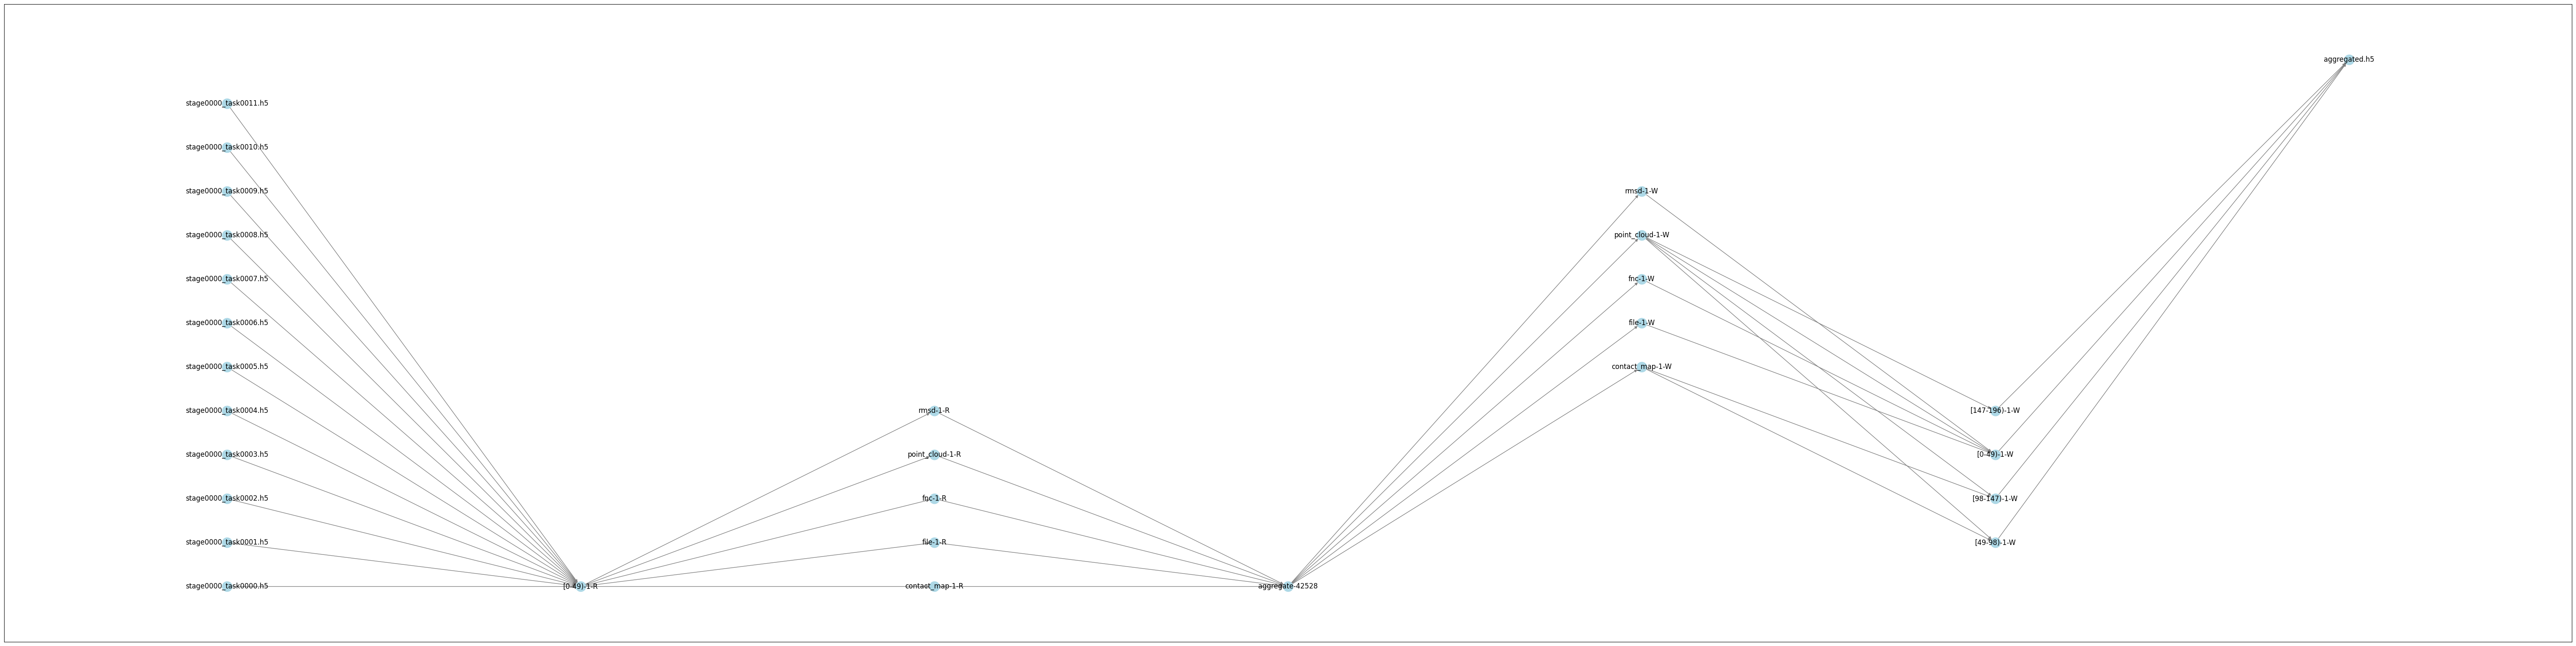

In [126]:
# G_VFD = vfd2g.set_task_position_full(G_VFD, task_file_map, STAGE_START)
# sp.display_all_nodes_attr(G_VFD)
all_edge_types = nx.get_edge_attributes(G_VFD,'edge_type')
edge_types = []
for edge in all_edge_types:
    edge_types.append(all_edge_types[edge])

print(f"edge_types: {set(edge_types)}")

sp.draw_graph(G_VFD, test_name, stat_path, graph_type="vfd", prefix=f'{(STAGE_END+1)}s', save=True)

In [127]:
# sp.display_all_edges_attr(G_VFD)
# sp.display_all_nodes_position(G_VFD)

# Add networkx to Sankey diagram

## Statistics for Sankey
Below are needed edge attributes before generating the sankey diagram:
- access_cnt : The total file/dataset access count 
- access_size : The total read and write access size
- operation : The operation type : read, write, read_write
- bandwidth : Get the per access size and time, then calculate the bandwidth. Average the bandwidth if multiple accesses. (TODO: currently only recording one access size and time)




In [128]:
# f2g.prepare_sankey_stat_full(G_VFD)
prepare_sankey_stat_full(G_VFD,vol_dset_info)
vfd2sk.time_to_file_x_pos(G_VFD)

edge: ('aggregate-42528', 'contact_map-1-W') -> task-dset
edge: ('aggregate-42528', 'file-1-W') -> task-dset
edge: ('aggregate-42528', 'fnc-1-W') -> task-dset
edge: ('aggregate-42528', 'point_cloud-1-W') -> task-dset
edge: ('aggregate-42528', 'rmsd-1-W') -> task-dset
edge: ('contact_map-1-R', 'aggregate-42528') -> dset-task
edge: ('file-1-R', 'aggregate-42528') -> dset-task
edge: ('fnc-1-R', 'aggregate-42528') -> dset-task
edge: ('point_cloud-1-R', 'aggregate-42528') -> dset-task
edge: ('rmsd-1-R', 'aggregate-42528') -> dset-task
All tasks:  ['aggregate-42528']
contact_map-1-R New pos:  (5.25, 0)
file-1-R New pos:  (5.25, 1)
fnc-1-R New pos:  (5.25, 2)
point_cloud-1-R New pos:  (5.25, 3)
rmsd-1-R New pos:  (5.25, 4)
contact_map-1-W New pos:  (6.75, 5)
file-1-W New pos:  (6.75, 6)
fnc-1-W New pos:  (6.75, 7)
point_cloud-1-W New pos:  (6.75, 8)
rmsd-1-W New pos:  (6.75, 9)


In [129]:
vfd_nodes, vfd_nodes_dict = vfd2sk.get_nodes_for_sankey(G_VFD, rm_tags=["-R", "-W"], label_on=True)

# print(vfd_nodes)

vfd_links = vfd2sk.get_links_for_sankey(G_VFD, vfd_nodes_dict, val_sqrt=False)
fig = go.Figure(go.Sankey(
            node = vfd_nodes,
            link = vfd_links, orientation='h'))

width = 1400
height = 800

fig.update_layout(
    autosize=False,
    width=width,
    height=height,
    margin=dict(
        l=width/10,
        r=width/10,
        b=height/10,
        t=height/4,
        # pad=2
    ),
    font=dict(size=18),
)


fig.show()
save_html_path = f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-labeled-s4.html"
fig.write_html(save_html_path)
print(f"Sankey saved to {save_html_path}")

bandwidth range: -91529693344927.45 B/s ~ 35.84 GB/s


Sankey saved to example_stat/ddmd/vfd-2s-ddmd-sankey-labeled-s4.html


In [130]:
stat_str = sp.show_vfd_stats(G_VFD)
print(stat_str)



Total number of links: 40
Total I/O size: 128.47 MB
Total I/O count: 12495
Total bandwidth: -172172852654064.19 B/s
Average I/O size: 10.28 KB
Medium I/O size: 3.21 MB
Inital input size: 0



In [131]:
# Create a manual legend using annotations.

def add_legend_to_graph(fig,save_img=False):
    LEGEND_ITEMS = {
        "Tasks":{"color":"red", "text":"Tasks"},
        "Files":{"color":"blue", "text":"Files"},
        "Edges":{"color":"lightblue", "text":"File bandwidth, darker the color, higher the bandwidth"},
    }

    legend_items = [
        go.layout.Annotation(
            x=0.9,  # X-coordinate for legend item
            y=0.85 - i * 0.03,  # Y-coordinate for legend item (adjust for position)
            xref='paper',
            yref='paper',
            text=f"{item_type} - {LEGEND_ITEMS[item_type]['color']}",
            showarrow=False,
            font=dict(size=14, color=LEGEND_ITEMS[item_type]['color']),
            # bordercolor='grey',  # Set the border color for the legend box
            # borderwidth=1,  # Set the border width for the legend box
            bgcolor='rgba(255, 255, 255, 0.7)',  # Add a transparent background color
        )
        for i, item_type in enumerate(LEGEND_ITEMS.keys())
    ]
    fig.update_layout(annotations=legend_items)
    fig.show()
    if save_img:
        fig.write_html(f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-annotated.html")
